# Columbus Crew xG Analysis — 2025 MLS Season
### Notebook 2: Applying the Model to Real Crew Data

---

**What this notebook does:**
1. Pulls real 2025 Columbus Crew match xG data from American Soccer Analysis
2. Loads your trained xG model from Notebook 1
3. Builds match-by-match performance analysis
4. Identifies matches where results didn't match xG (luck vs skill)
5. Creates all visualizations for the dashboard
6. Exports JSON files for the JavaScript frontend

**Team ID:** `mvzqoLZQap` (Columbus Crew)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import json
import os
import joblib

from itscalledsoccer.client import AmericanSoccerAnalysis
from mplsoccer import Pitch

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

CREW_GOLD  = '#F5C518'
CREW_BLACK = '#14130F'
CREW_GREY  = '#2A2820'
CREW_ID    = 'mvzqoLZQap'

os.makedirs('../assets', exist_ok=True)
os.makedirs('../dashboard/data', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

print('Setup complete!')

Setup complete!


## Step 1: Load Your Trained xG Model

In [3]:
xg_model = joblib.load('models/xg_model.pkl')

with open('models/model_meta.json') as f:
    model_meta = json.load(f)

print('Model loaded!')
print(f'  AUC       : {model_meta["auc"]}')
print(f'  Log Loss  : {model_meta["log_loss"]}')
print(f'  Trained on: {model_meta["training_shots"]:,} shots')

Model loaded!
  AUC       : 0.7857
  Log Loss  : 0.3359
  Trained on: 203 shots


## Step 2: Pull Columbus Crew 2025 Match Data

In [4]:
api = AmericanSoccerAnalysis()

# Pull all 2025 Crew matches
raw = api.get_game_xgoals(
    leagues="mls",
    season_name="2025",
    team_ids=CREW_ID
)

print(f'Matches returned: {len(raw)}')
print(f'Columns: {list(raw.columns)}')
raw.head()

Matches returned: 37
Columns: ['game_id', 'date_time_utc', 'home_team_id', 'home_goals', 'home_team_xgoals', 'home_player_xgoals', 'away_team_id', 'away_goals', 'away_team_xgoals', 'away_player_xgoals', 'goal_difference', 'team_xgoal_difference', 'player_xgoal_difference', 'final_score_difference', 'home_xpoints', 'away_xpoints']


,game_id,date_time_utc,home_team_id,home_goals,home_team_xgoals,home_player_xgoals,away_team_id,away_goals,away_team_xgoals,away_player_xgoals,goal_difference,team_xgoal_difference,player_xgoal_difference,final_score_difference,home_xpoints,away_xpoints
0,N6MmgRjZqE,2025-11-08 23:00:00 UTC,NWMWlBK5lz,2,1.211,1.214,mvzqoLZQap,1,1.578,1.587,1,-0.367,-0.372,1,0.000,0.000
1,kRQald7oqK,2025-11-02 23:30:00 UTC,mvzqoLZQap,4,3.280,3.521,NWMWlBK5lz,0,0.062,0.062,4,3.219,3.460,4,0.000,0.000
2,Vj589oV4q8,2025-10-27 22:45:00 UTC,NWMWlBK5lz,1,1.709,1.715,mvzqoLZQap,0,0.816,0.816,1,0.894,0.899,1,0.000,0.000
3,gjMNpb2BqK,2025-10-18 22:00:00 UTC,mvzqoLZQap,3,2.294,2.302,a2lqRX2Mr0,1,0.845,0.845,2,1.449,1.457,2,2.394,0.438
4,gpMOpbA15z,2025-10-04 23:30:00 UTC,jYQJ8EW5GR,1,0.853,0.862,mvzqoLZQap,1,3.166,3.259,0,-2.313,-2.397,0,0.196,2.710


## Step 3: Build Clean Match DataFrame

The API returns one row per match with home/away columns.
We reshape this so every row is from the Crew's perspective.

In [5]:
# Pull opponent names for joining
teams = api.get_teams(leagues="mls")
team_lookup = teams.set_index('team_id')['team_name'].to_dict()

matches = []
for _, row in raw.iterrows():
    is_home = row['home_team_id'] == CREW_ID

    if is_home:
        xg_for     = row['home_team_xgoals']
        xg_ag      = row['away_team_xgoals']
        goals_for  = row['home_goals']
        goals_ag   = row['away_goals']
        opp_id     = row['away_team_id']
    else:
        xg_for     = row['away_team_xgoals']
        xg_ag      = row['home_team_xgoals']
        goals_for  = row['away_goals']
        goals_ag   = row['home_goals']
        opp_id     = row['home_team_id']

    if goals_for > goals_ag:   result = 'W'
    elif goals_for == goals_ag: result = 'D'
    else:                       result = 'L'

    # xG result — who SHOULD have won based on chances
    if xg_for > xg_ag + 0.3:    xg_result = 'xW'
    elif xg_ag > xg_for + 0.3:  xg_result = 'xL'
    else:                        xg_result = 'xD'

    # Did the result match what xG suggested?
    deserved = (
        (result == 'W' and xg_result == 'xW') or
        (result == 'D' and xg_result == 'xD') or
        (result == 'L' and xg_result == 'xL')
    )

    matches.append({
        'date':       str(row['date_time_utc'])[:10],
        'opponent':   team_lookup.get(opp_id, opp_id),
        'venue':      'Home' if is_home else 'Away',
        'goals_for':  int(goals_for),
        'goals_ag':   int(goals_ag),
        'xg_for':     round(float(xg_for), 2),
        'xg_ag':      round(float(xg_ag), 2),
        'xg_diff':    round(float(xg_for) - float(xg_ag), 2),
        'result':     result,
        'xg_result':  xg_result,
        'deserved':   deserved,
    })

crew = pd.DataFrame(matches).sort_values('date').reset_index(drop=True)

# Cumulative columns for trend chart
crew['cumulative_xg']    = crew['xg_for'].cumsum().round(2)
crew['cumulative_xga']   = crew['xg_ag'].cumsum().round(2)
crew['cumulative_goals'] = crew['goals_for'].cumsum()

print(f'Matches processed: {len(crew)}')
crew[['date','opponent','venue','result','xg_result','deserved','xg_for','xg_ag','xg_diff']].head(10)

Matches processed: 37


,date,opponent,venue,result,xg_result,deserved,xg_for,xg_ag,xg_diff
0,2025-02-23,Chicago Fire FC,Home,W,xW,True,2.310,1.840,0.470
1,2025-03-02,New England Revolution,Away,W,xD,False,0.690,0.480,0.210
2,2025-03-08,Houston Dynamo FC,Home,D,xW,False,0.710,0.400,0.310
3,2025-03-16,San Diego FC,Away,D,xL,False,0.980,2.480,-1.500
4,2025-03-22,New York City FC,Home,D,xW,False,1.740,0.320,1.430
5,2025-03-29,D.C. United,Away,W,xD,False,1.290,1.120,0.170
6,2025-04-05,CF Montréal,Home,W,xW,True,1.480,0.350,1.120
7,2025-04-13,St. Louis City SC,Away,W,xD,False,1.820,1.930,-0.110
8,2025-04-19,Inter Miami CF,Home,L,xW,False,3.000,0.590,2.410
9,2025-04-26,San Jose Earthquakes,Home,W,xL,False,1.630,2.300,-0.670


## Step 4: Key Findings

These are the insights that go in your README and LinkedIn post.

In [6]:
W = (crew['result'] == 'W').sum()
D = (crew['result'] == 'D').sum()
L = (crew['result'] == 'L').sum()

lucky_wins   = crew[(crew['result'] == 'W') & (crew['xg_result'] == 'xL')]
unlucky_loss = crew[(crew['result'] == 'L') & (crew['xg_result'] == 'xW')]
deserved     = crew[crew['deserved'] == True]

print('=' * 55)
print('  COLUMBUS CREW 2025 — xG SEASON ANALYSIS')
print('=' * 55)
print(f'  Record          : {W}W {D}D {L}L')
print(f'  Total xG For    : {crew["xg_for"].sum():.2f}')
print(f'  Total xG Against: {crew["xg_ag"].sum():.2f}')
print(f'  Actual Goals    : {crew["goals_for"].sum()}')
print(f'  xG Diff (season): {crew["xg_diff"].sum():+.2f}')
print(f'  Deserved results: {len(deserved)}/{len(crew)} matches ({len(deserved)/len(crew):.0%})')
print()
print(f'  Lucky wins (won but xG said loss)   : {len(lucky_wins)}')
for _, r in lucky_wins.iterrows():
    print(f'    vs {r["opponent"]} ({r["date"]}) — xG {r["xg_for"]:.2f} vs {r["xg_ag"]:.2f}')
print()
print(f'  Unlucky losses (lost but xG said win): {len(unlucky_loss)}')
for _, r in unlucky_loss.iterrows():
    print(f'    vs {r["opponent"]} ({r["date"]}) — xG {r["xg_for"]:.2f} vs {r["xg_ag"]:.2f}')
print('=' * 55)

  COLUMBUS CREW 2025 — xG SEASON ANALYSIS
  Record          : 15W 11D 11L
  Total xG For    : 61.53
  Total xG Against: 53.20
  Actual Goals    : 57
  xG Diff (season): +8.26
  Deserved results: 15/37 matches (41%)

  Lucky wins (won but xG said loss)   : 2
    vs San Jose Earthquakes (2025-04-26) — xG 1.63 vs 2.30
    vs Atlanta United FC (2025-09-13) — xG 0.95 vs 2.69

  Unlucky losses (lost but xG said win): 3
    vs Inter Miami CF (2025-04-19) — xG 3.00 vs 0.59
    vs Orlando City SC (2025-07-26) — xG 2.15 vs 1.81
    vs FC Cincinnati (2025-11-08) — xG 1.58 vs 1.21


## Step 5: Visualizations

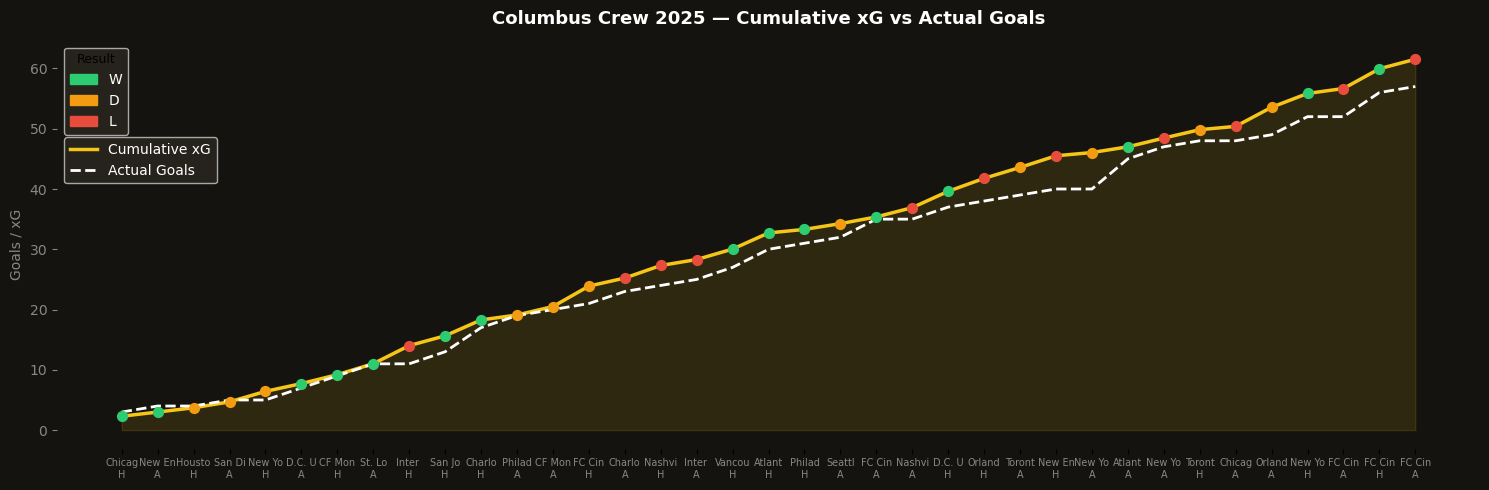

Saved: assets/xg_trend.png


In [15]:
# ── Chart 1: Cumulative xG vs Actual Goals ────────────────
result_colors = {'W': '#2ecc71', 'D': '#f39c12', 'L': '#e74c3c'}

fig, ax = plt.subplots(figsize=(15, 5))
fig.patch.set_facecolor(CREW_BLACK)
ax.set_facecolor(CREW_BLACK)

x = range(len(crew))

ax.fill_between(x, crew['cumulative_xg'], alpha=0.12, color=CREW_GOLD)
ax.plot(x, crew['cumulative_xg'],
        color=CREW_GOLD, linewidth=2.5, label='Cumulative xG')
ax.plot(x, crew['cumulative_goals'],
        color='white', linewidth=2, linestyle='--', label='Actual Goals')

for i, row in crew.iterrows():
    ax.scatter(i, row['cumulative_xg'],
               color=result_colors[row['result']], s=50, zorder=5)

patches = [mpatches.Patch(color=v, label=k) for k, v in result_colors.items()]
leg1 = ax.legend(handles=patches, loc='upper left',
                 facecolor=CREW_GREY, labelcolor='white',
                 title='Result', title_fontsize=9)
ax.add_artist(leg1)
ax.legend(loc='upper left', bbox_to_anchor=(0, 0.78),
          facecolor=CREW_GREY, labelcolor='white')

ax.set_xticks(range(len(crew)))
ax.set_xticklabels(
    [f"{r['opponent'][:6]}\n{r['venue'][0]}" for _, r in crew.iterrows()],
    fontsize=7, color='#888'
)
ax.tick_params(axis='y', colors='#888')
ax.spines[:].set_visible(False)
ax.set_title('Columbus Crew 2025 — Cumulative xG vs Actual Goals',
             color='white', fontsize=13, fontweight='bold', pad=12)
ax.set_ylabel('Goals / xG', color='#888')

plt.tight_layout()
plt.savefig('assets/xg_trend.png', dpi=150, bbox_inches='tight', facecolor=CREW_BLACK)
plt.show()
print('Saved: assets/xg_trend.png')

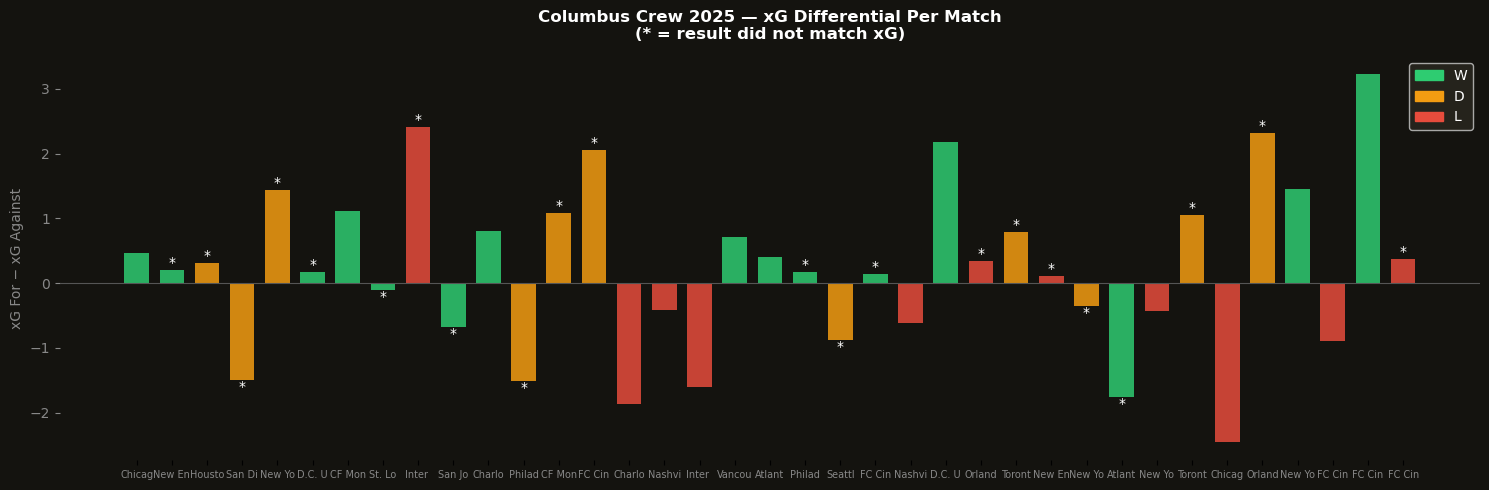

Saved: assets/xg_differential.png


In [14]:
# ── Chart 2: Match xG Differential ───────────────────────
fig, ax = plt.subplots(figsize=(15, 5))
fig.patch.set_facecolor(CREW_BLACK)
ax.set_facecolor(CREW_BLACK)

bar_colors = [result_colors[r] for r in crew['result']]
ax.bar(range(len(crew)), crew['xg_diff'], color=bar_colors, alpha=0.85, width=0.7)
ax.axhline(0, color='#555', linewidth=0.8)

# Mark undeserved results
for i, row in crew.iterrows():
    if not row['deserved']:
        ax.annotate('*', (i, row['xg_diff']),
                    ha='center', va='bottom' if row['xg_diff'] >= 0 else 'top',
                    color='white', fontsize=10)

ax.set_xticks(range(len(crew)))
ax.set_xticklabels(
    [f"{r['opponent'][:6]}" for _, r in crew.iterrows()],
    fontsize=7, color='#888'
)
ax.tick_params(axis='y', colors='#888')
ax.spines[:].set_visible(False)
ax.set_title('Columbus Crew 2025 — xG Differential Per Match\n(* = result did not match xG)',
             color='white', fontsize=12, fontweight='bold', pad=12)
ax.set_ylabel('xG For − xG Against', color='#888')

patches = [mpatches.Patch(color=v, label=k) for k, v in result_colors.items()]
ax.legend(handles=patches, facecolor=CREW_GREY, labelcolor='white')

plt.tight_layout()
plt.savefig('assets/xg_differential.png', dpi=150, bbox_inches='tight', facecolor=CREW_BLACK)
plt.show()
print('Saved: assets/xg_differential.png')

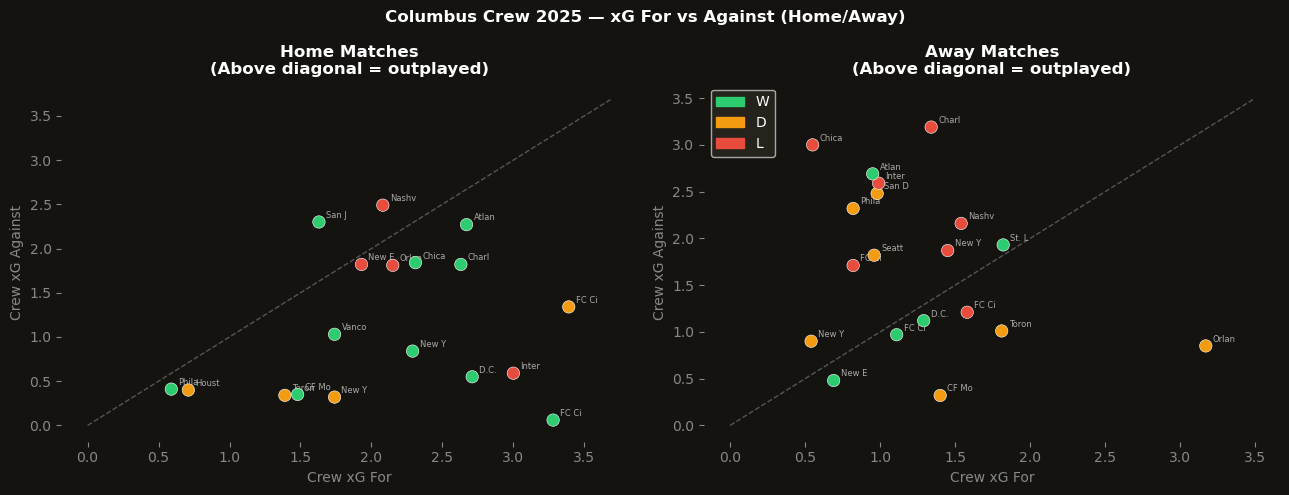

Saved: assets/home_away_xg.png


In [13]:
# ── Chart 3: Home vs Away xG ──────────────────────────────
home = crew[crew['venue'] == 'Home']
away = crew[crew['venue'] == 'Away']

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.patch.set_facecolor(CREW_BLACK)

for ax, subset, label in zip(axes, [home, away], ['Home', 'Away']):
    ax.set_facecolor(CREW_BLACK)

    ax.scatter(subset['xg_for'], subset['xg_ag'],
               c=[result_colors[r] for r in subset['result']],
               s=80, zorder=5, edgecolors='white', linewidth=0.4)

    # Diagonal — equal xG
    lim = max(subset['xg_for'].max(), subset['xg_ag'].max()) + 0.3
    ax.plot([0, lim], [0, lim], '--', color='#555', linewidth=1)

    # Label opponent
    for _, row in subset.iterrows():
        ax.annotate(row['opponent'][:5],
                    (row['xg_for'], row['xg_ag']),
                    textcoords='offset points', xytext=(5, 3),
                    fontsize=6, color='#aaa')

    ax.set_xlabel('Crew xG For', color='#888')
    ax.set_ylabel('Crew xG Against', color='#888')
    ax.tick_params(colors='#888')
    ax.spines[:].set_visible(False)
    ax.set_title(f'{label} Matches\n(Above diagonal = outplayed)',
                 color='white', fontweight='bold')

patches = [mpatches.Patch(color=v, label=k) for k, v in result_colors.items()]
axes[1].legend(handles=patches, facecolor=CREW_GREY, labelcolor='white')

plt.suptitle('Columbus Crew 2025 — xG For vs Against (Home/Away)',
             color='white', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('assets/home_away_xg.png', dpi=150, bbox_inches='tight', facecolor=CREW_BLACK)
plt.show()
print('Saved: assets/home_away_xg.png')

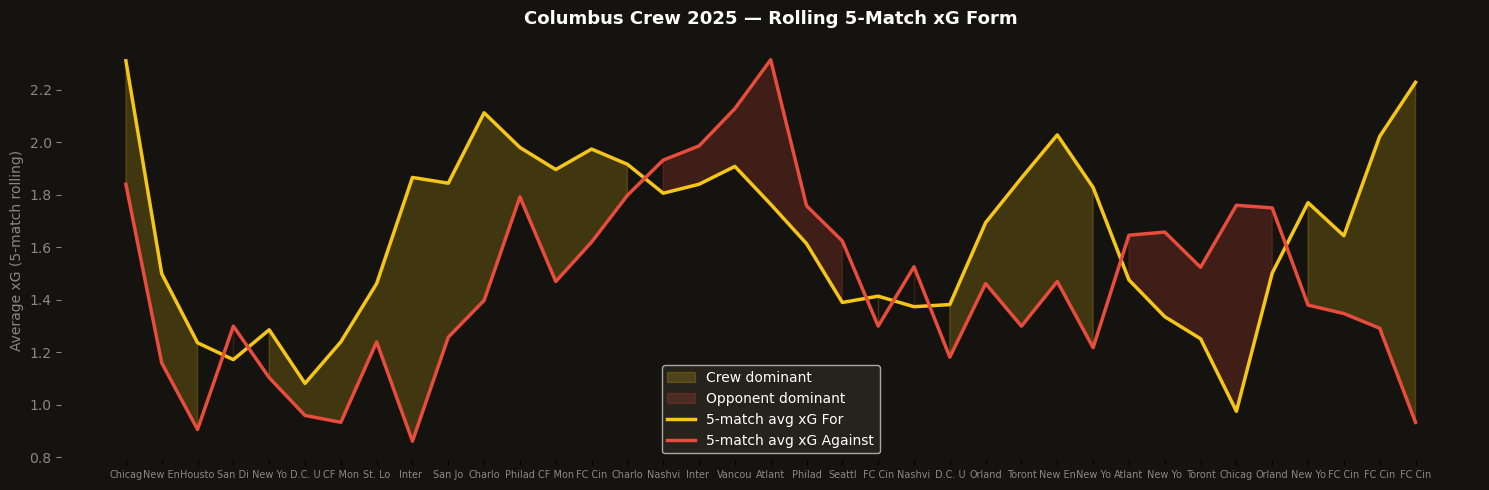

Saved: assets/rolling_xg_form.png


In [12]:
# ── Chart 4: Rolling xG Form (5-match window) ─────────────
# Shows momentum — are the Crew getting better or worse?
crew['rolling_xg_for'] = crew['xg_for'].rolling(5, min_periods=1).mean()
crew['rolling_xg_ag']  = crew['xg_ag'].rolling(5, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(15, 5))
fig.patch.set_facecolor(CREW_BLACK)
ax.set_facecolor(CREW_BLACK)

x = range(len(crew))
ax.fill_between(x, crew['rolling_xg_for'], crew['rolling_xg_ag'],
                where=crew['rolling_xg_for'] >= crew['rolling_xg_ag'],
                alpha=0.2, color=CREW_GOLD, label='Crew dominant')
ax.fill_between(x, crew['rolling_xg_for'], crew['rolling_xg_ag'],
                where=crew['rolling_xg_for'] < crew['rolling_xg_ag'],
                alpha=0.2, color='#e74c3c', label='Opponent dominant')

ax.plot(x, crew['rolling_xg_for'], color=CREW_GOLD, linewidth=2.5, label='5-match avg xG For')
ax.plot(x, crew['rolling_xg_ag'],  color='#e74c3c',  linewidth=2.5, label='5-match avg xG Against')

ax.set_xticks(range(len(crew)))
ax.set_xticklabels(
    [f"{r['opponent'][:6]}" for _, r in crew.iterrows()],
    fontsize=7, color='#888'
)
ax.tick_params(axis='y', colors='#888')
ax.spines[:].set_visible(False)
ax.set_title('Columbus Crew 2025 — Rolling 5-Match xG Form',
             color='white', fontsize=13, fontweight='bold', pad=12)
ax.set_ylabel('Average xG (5-match rolling)', color='#888')
ax.legend(facecolor=CREW_GREY, labelcolor='white')

plt.tight_layout()
plt.savefig('assets/rolling_xg_form.png', dpi=150, bbox_inches='tight', facecolor=CREW_BLACK)
plt.show()
print('Saved: assets/rolling_xg_form.png')

## Step 6: Export JSON for Dashboard

In [11]:
# Match-level JSON
match_records = crew.to_dict(orient='records')
with open('../dashboard/data/match_xg.json', 'w') as f:
    json.dump(match_records, f, indent=2, default=str)
print(f'Exported {len(match_records)} matches to dashboard/data/match_xg.json')

# Season summary JSON (for dashboard header stats)
summary = {
    'team':           'Columbus Crew',
    'season':         '2025',
    'matches':        len(crew),
    'wins':           int(W),
    'draws':          int(D),
    'losses':         int(L),
    'total_xg_for':   round(float(crew['xg_for'].sum()), 2),
    'total_xg_ag':    round(float(crew['xg_ag'].sum()), 2),
    'total_goals':    int(crew['goals_for'].sum()),
    'xg_diff':        round(float(crew['xg_diff'].sum()), 2),
    'lucky_wins':     int(len(lucky_wins)),
    'unlucky_losses': int(len(unlucky_loss)),
    'deserved_pct':   round(len(deserved) / len(crew) * 100, 1)
}

with open('../dashboard/data/season_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print('Exported season_summary.json')
print()
print(json.dumps(summary, indent=2))

Exported 37 matches to dashboard/data/match_xg.json
Exported season_summary.json

{
  "team": "Columbus Crew",
  "season": "2025",
  "matches": 37,
  "wins": 15,
  "draws": 11,
  "losses": 11,
  "total_xg_for": 61.53,
  "total_xg_ag": 53.2,
  "total_goals": 57,
  "xg_diff": 8.26,
  "lucky_wins": 2,
  "unlucky_losses": 3,
  "deserved_pct": 40.5
}


## What You Now Have

| Output | Location | Used for |
|---|---|---|
| xG Trend chart | `assets/xg_trend.png` | README hero image |
| xG Differential | `assets/xg_differential.png` | Dashboard section 2 |
| Home/Away xG scatter | `assets/home_away_xg.png` | Dashboard section 3 |
| Rolling xG form | `assets/rolling_xg_form.png` | Dashboard section 4 |
| match_xg.json | `dashboard/data/` | JS charts |
| season_summary.json | `dashboard/data/` | Dashboard header stats |

**Next: Notebook 3** — build the JavaScript dashboard that loads these files and makes everything interactive and shareable on GitHub Pages.

---

**Your README key findings come from the Season Summary printout above.**
Copy those numbers directly into your README and LinkedIn post.